In [1]:
import sys ,os, importlib
import pandas as pd
import configparser
import matplotlib.pyplot as plt
import cv2
import zipfile
from tqdm import tqdm
import glob

p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

import data_processing.data_processing_functions as DP
import utils as Utils
importlib.reload(Utils)
importlib.reload(DP)

config = configparser.ConfigParser()
config.read("../../config.ini")
pd.set_option('display.max_colwidth', None)


In [2]:
CNCB_COVID_CT_PATH = config['PATHS']['CNCB_COVID_CT_PATH']
METADATA_PATH = os.path.join(CNCB_COVID_CT_PATH, 'metadata.csv')
LESION_SLICES_PATH = os.path.join(CNCB_COVID_CT_PATH, 'lesions_slices.csv')
SEGMENTED_CNCB = os.path.join(CNCB_COVID_CT_PATH, 'ct_lesion_seg')

~~Error extracting COVID19-13.zip check this!!~~ Solved by dowloading again

In [57]:
# Unzip all files in the folder
Utils.unzip_and_remove_all("/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/Normal-controls")

100%|██████████| 4/4 [15:44<00:00, 236.19s/it]


## Cheking the downloaded metadata

In [4]:
unzip_file_names_path = os.path.join(CNCB_COVID_CT_PATH, 'unzip_filenames.csv')
unzip_file_names_df = pd.read_csv(unzip_file_names_path)
unzip_file_names_df["folder"] = unzip_file_names_df["zip_file"].apply(lambda x: x.split(".")[0])
unzip_file_names_df["folder_id"] = unzip_file_names_df["folder"].apply(lambda x: x.split("-")[1].split(".")[0])
print(unzip_file_names_df.shape)
print(unzip_file_names_df.head())
print(unzip_file_names_df.dtypes)
print(unzip_file_names_df['scan_id'].nunique())
# group by label and get min and max scan_id
print(unzip_file_names_df.groupby('label')['scan_id'].agg(['min', 'max']))
print(unzip_file_names_df.groupby('label')['patient_id'].agg(['min', 'max']))

(4178, 7)
   zip_file label  patient_id  scan_id  n_slice folder folder_id
0  CP-1.zip    CP           0     3131      285   CP-1         1
1  CP-1.zip    CP           0     3132       42   CP-1         1
2  CP-1.zip    CP           0     3133      290   CP-1         1
3  CP-1.zip    CP           0     3134       37   CP-1         1
4  CP-1.zip    CP           0     3135      269   CP-1         1
zip_file      object
label         object
patient_id     int64
scan_id        int64
n_slice        int64
folder        object
folder_id     object
dtype: object
4178
         min   max
label             
CP      2887  5779
NCP     1164  5539
Normal    90  5459
        min   max
label            
CP        0  4044
NCP      16  3999
Normal  742  3916


In [56]:
unzip_file_names_df[unzip_file_names_df['label'] == 'NCP']['scan_id'].min()

1164

## Segmentation CTS (ONLY 150 CTS)

In [3]:
seg_meta_df = DP.read_cnbc_folder_structure(SEGMENTED_CNCB)

print(f"Number of CT slices: {len(seg_meta_df)}")
seg_meta_df.head()

Number of CT scans: 21470


,scan_index,slice_index,image_path,n_slices,mask_path,n_masks
0,26,48,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/ct_lesion_seg/image/26/48.jpg,132,NaN,NaN
1,26,130,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/ct_lesion_seg/image/26/130.jpg,132,NaN,NaN
2,26,0,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/ct_lesion_seg/image/26/0.jpg,132,NaN,NaN
3,26,82,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/ct_lesion_seg/image/26/82.jpg,132,NaN,NaN
4,26,71,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/ct_lesion_seg/image/26/71.jpg,132,NaN,NaN


In [38]:
SEGMENTED_CNCB = os.path.join(CNCB_COVID_CT_PATH, 'ct_lesion_seg')
IMAGE_PATH = os.path.join(SEGMENTED_CNCB, 'image')
MASKS_PATH = os.path.join(SEGMENTED_CNCB, 'mask')
# count mask NaN using Pandas native function
print(seg_meta_df["mask"].isna().sum())
print(seg_meta_df["mask"].notna().sum())
print(seg_meta_df["mask"].isna().sum() + seg_meta_df["mask"].notna().sum())
# get all .png files in the folder
print(f"All CT slices : {len(Utils.get_all_files(IMAGE_PATH, '.jpg'))}")
print(f"All mask slices : {len(Utils.get_all_files(MASKS_PATH, '.png'))}")

20720
750
21470
All CT slices : 21470
All mask slices : 750


### Visualize CNCB segmentation masks

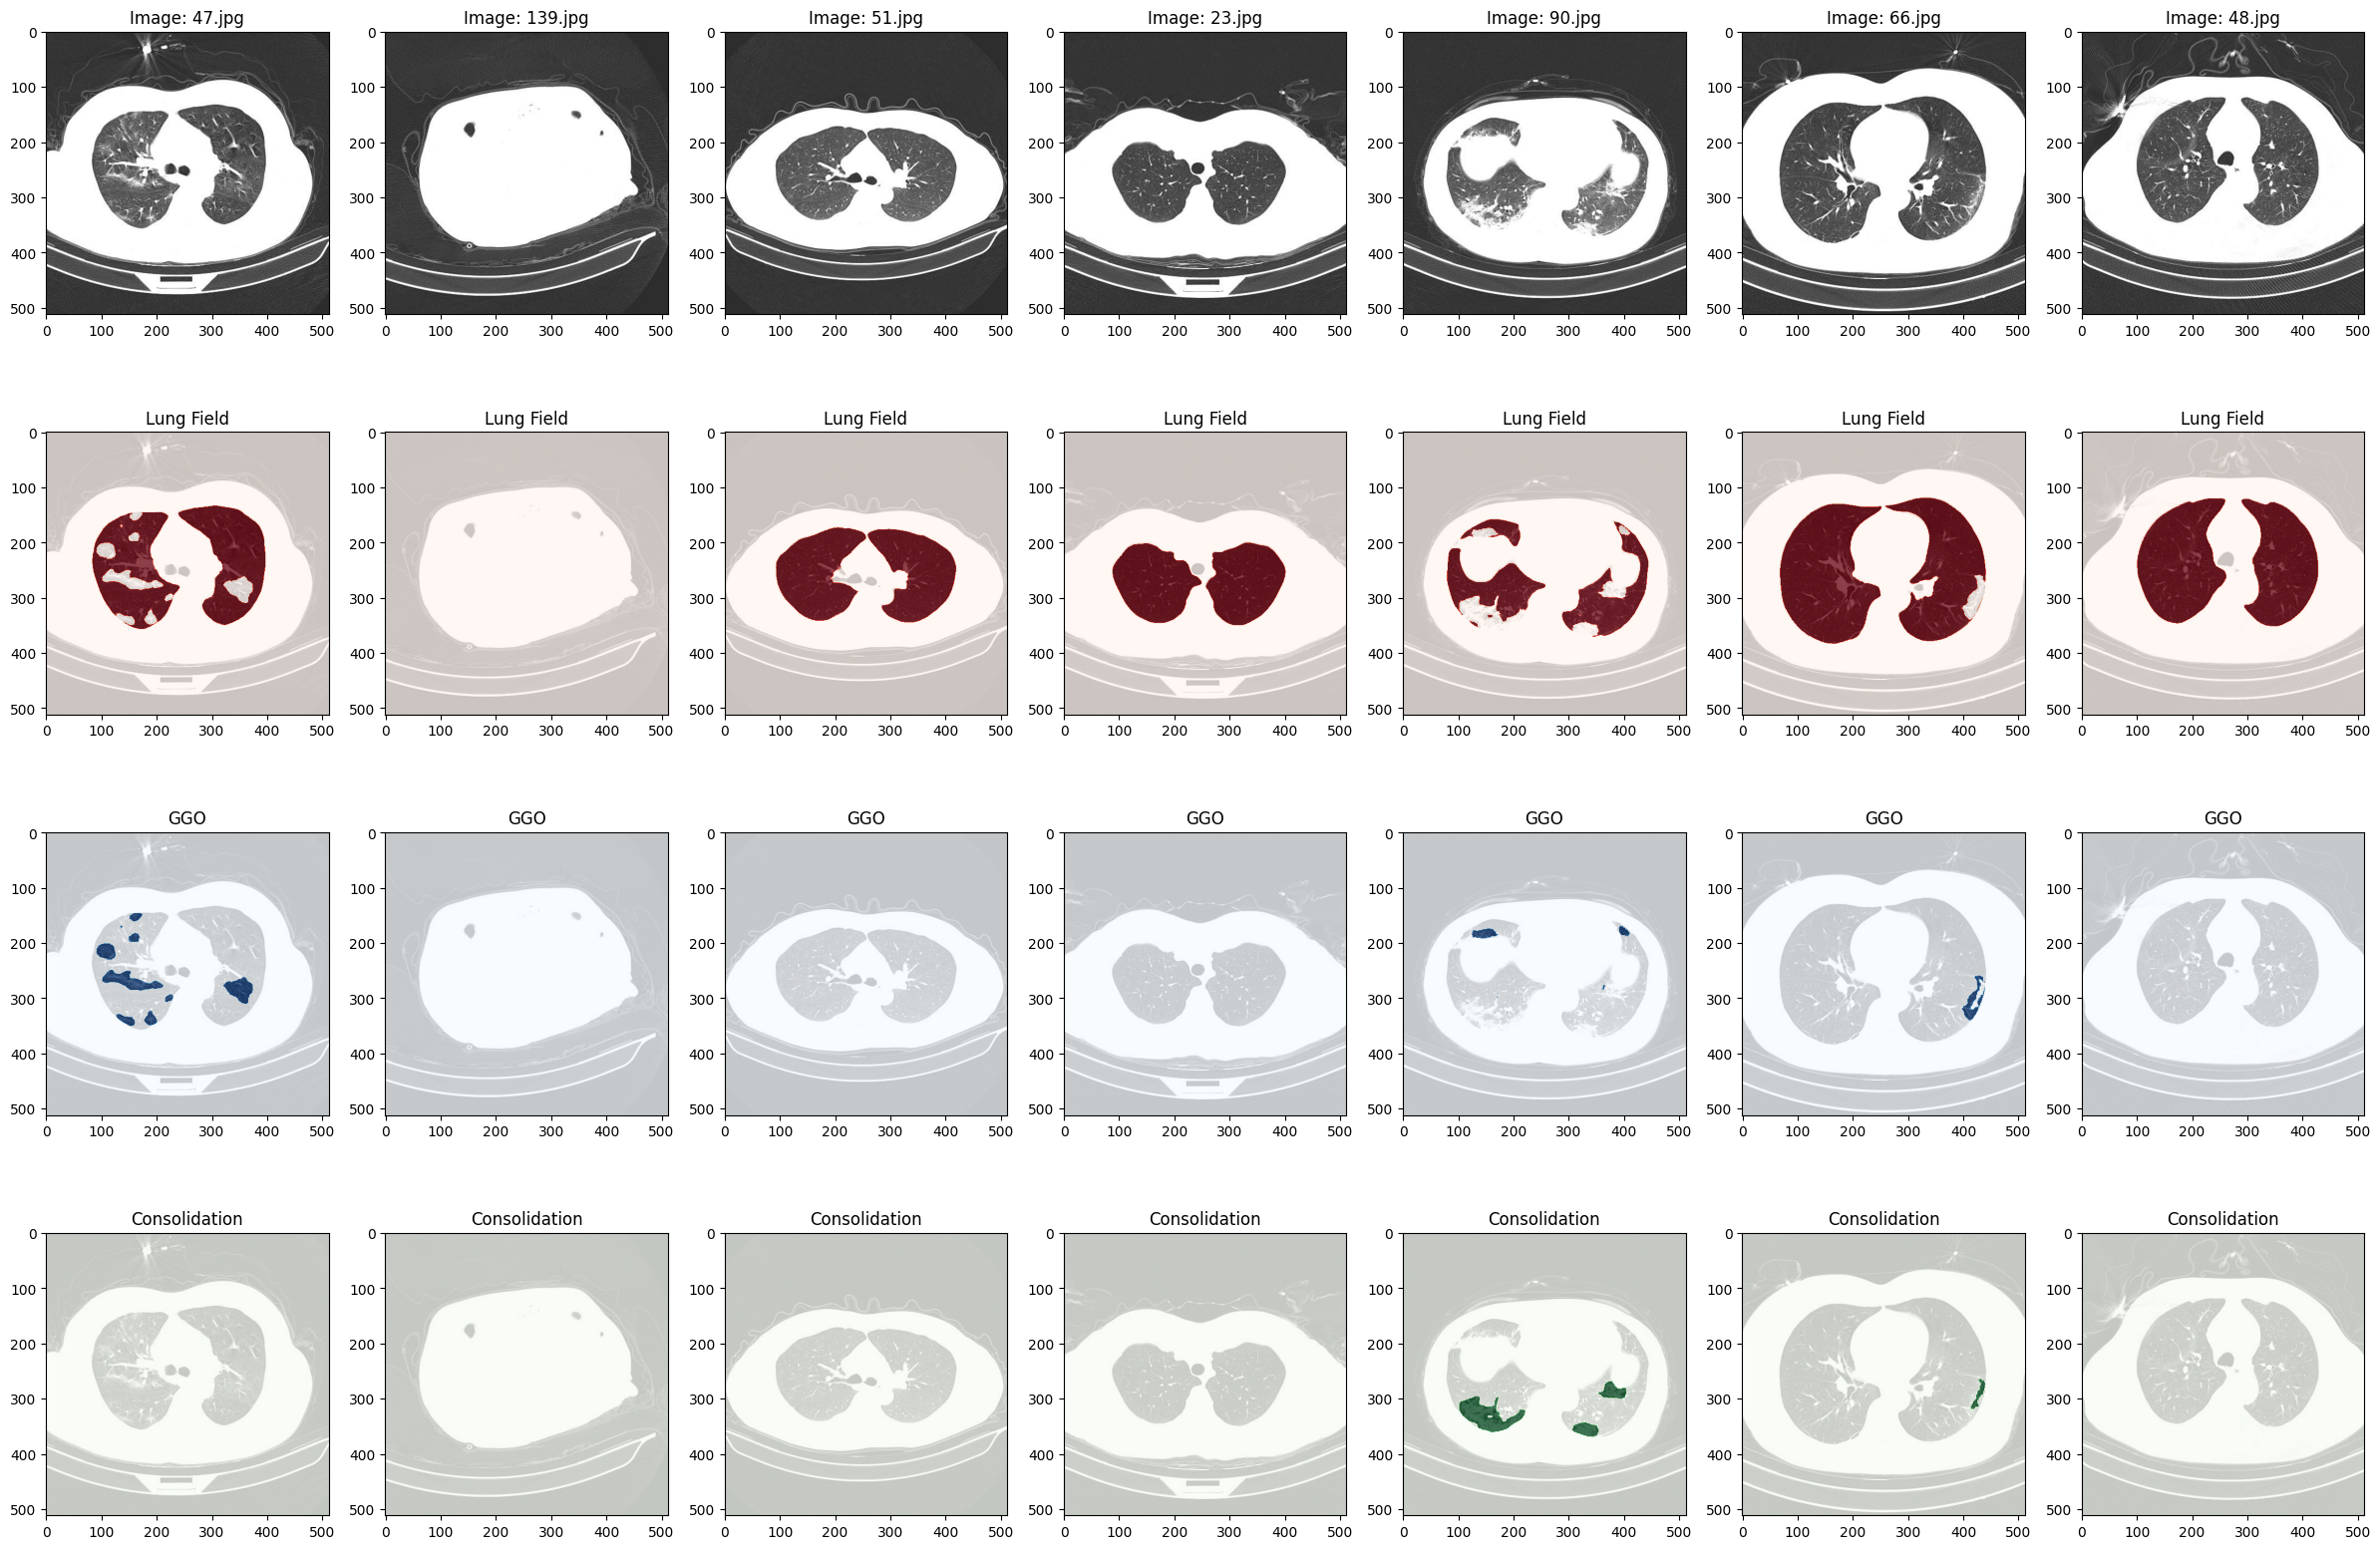

In [53]:
cncb_slices_with_mask_df = seg_meta_df[seg_meta_df["mask"].notna()]
N_SAMPLES = 7

# get random samples
cncb_slices_with_mask_df = cncb_slices_with_mask_df.sample(N_SAMPLES)

fig, ax = plt.subplots(4,N_SAMPLES, figsize=(30, 20))
for i in range(0, N_SAMPLES):
    # get image path
    image_path = cncb_slices_with_mask_df.iloc[i]["image"]
    # get mask path
    mask_path = cncb_slices_with_mask_df.iloc[i]["mask"]
    # read image
    image = cv2.imread(image_path)
    # read mask
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    # get mask 1 values
    mask_lung_field = mask == 1
    # get mask 2 values
    mask_ggo = mask == 2
    # get mask 3 values
    mask_consolidation = mask == 3
    # plot image and masks
    ax[0,i].imshow(image, cmap='gray')
    # title
    ax[0,i].set_title(f"Image: {image_path.split('/')[-1]}")
    ax[1,i].imshow(image, cmap='gray')
    ax[1,i].imshow(mask_lung_field, cmap='Reds', alpha=0.75)
    ax[1,i].set_title(f"Lung Field")
    ax[2,i].imshow(image, cmap='gray')
    ax[2,i].imshow(mask_ggo, cmap='Blues', alpha=0.75)
    ax[2,i].set_title(f"GGO")
    ax[3,i].imshow(image, cmap='gray')
    ax[3,i].imshow(mask_consolidation, cmap='Greens', alpha=0.75)
    ax[3,i].set_title(f"Consolidation")
plt.show()

# Lesion slices metadata

In [8]:
lesion_slices_df = pd.read_csv(LESION_SLICES_PATH)
lesion_slices_df["label"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[0]).apply(lambda x: "covid" if x == "NCP" else "common-pneumonia")
lesion_slices_df["patient_index"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[1])
lesion_slices_df["scan_index"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[2])
lesion_slices_df["slice_index"] = lesion_slices_df["imgpath"].apply(lambda x: x.split("/")[3].split(".")[0])

print(f"Number of CT scans: {len(lesion_slices_df)}")
print(lesion_slices_df.groupby(by="label").size())
lesion_slices_df.head()

Number of CT scans: 58766
label
common-pneumonia    36894
covid               21872
dtype: int64


,imgpath,label,patient_index,scan_index,slice_index
0,CP/3783/5727/0008.png,common-pneumonia,3783,5727,0008
1,CP/3783/5727/0009.png,common-pneumonia,3783,5727,0009
2,CP/3783/5727/0010.png,common-pneumonia,3783,5727,0010
3,CP/3783/5727/0011.png,common-pneumonia,3783,5727,0011
4,CP/3783/5727/0012.png,common-pneumonia,3783,5727,0012


## Checking if the images with segmentation masks correspond to any in the NCP category

In [62]:
all_file_paths = glob.glob("/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/COVID19*/*/*/*/*.png")
print(f"Number of CT scans: {len(all_file_paths)}")

Number of CT scans: 112301


In [10]:
covid_unzip_file_names_df = unzip_file_names_df[unzip_file_names_df['label'] == 'NCP'].copy()

<BarContainer object of 1544 artists>

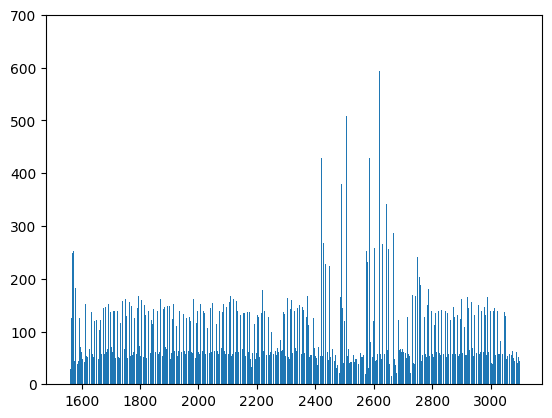

In [78]:

covid_unzip_file_names_df["scan_folders"] = CNCB_COVID_CT_PATH + "/" + "COVID19-" + covid_unzip_file_names_df["folder_id"] + "/NCP/" + covid_unzip_file_names_df["patient_id"].astype(str) + "/" + covid_unzip_file_names_df["scan_id"].astype(str)
covid_unzip_file_names_df.head()

,zip_file,label,patient_id,scan_id,n_slice,folder,folder_id,scan_folders
1556,NCP-1.zip,NCP,100,1337,139,NCP-1,1,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/COVID19-1/NCP/100/1337
1557,NCP-1.zip,NCP,100,1338,58,NCP-1,1,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/COVID19-1/NCP/100/1338
1558,NCP-1.zip,NCP,1001,2559,141,NCP-1,1,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/COVID19-1/NCP/1001/2559
1559,NCP-1.zip,NCP,1002,2561,58,NCP-1,1,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/COVID19-1/NCP/1002/2561
1560,NCP-1.zip,NCP,1008,2569,387,NCP-1,1,/media/my_ftp/BasesDeDatos_Torax_RX_CT/COVID19_CT/CNCB_COVID_CT/COVID19-1/NCP/1008/2569


In [88]:
import numpy as np

scan_seg_meta_df = seg_meta_df[seg_meta_df["mask"].notna()]

# Load all images from scan_seg_meta_df["image"] into memory
images_dict = {image_path: cv2.imread(image_path) for image_path in tqdm(scan_seg_meta_df["image"], total=len(scan_seg_meta_df))}
matches_dict = {}
# Iterate over the folders in covid_unzip_file_names_df["scan_folders"]
for covid_image_folder in tqdm(covid_unzip_file_names_df["scan_folders"], total=len(covid_unzip_file_names_df)):
    # For each folder, iterate over the images in the folder
    for covid_image_path in glob.glob(covid_image_folder + "/*.png"):
        covid_image = cv2.imread(covid_image_path)
        # For each image in the folder, compare it with all images in the dictionary
        for image_path, image in images_dict.items():
            if np.array_equal(image, covid_image):
                matches_dict[image_path] = covid_image_path
                break
matches_dict

 90%|████████▉ | 1389/1544 [2:20:48<19:47,  7.66s/it] 

NameError: name 'matches_dict' is not defined